# TRABAJO PRÁCTICO 11 - PYMC

In [1]:
# LIBRERIAS
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az

import os



WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [2]:
url = 'https://raw.githubusercontent.com/mvera1412/TA136-TB056-TB057-8625/main/data/TA136.csv'

# Se asigna el nombre del csv
filename = "TA136.csv"

# Se descarga el csv si no está en el directorio
if not os.path.exists(filename):
    print("Archivo no encontrado. Descargando...")
    !wget -O {filename} {url}
else:
    print("Archivo ya existe, no se descarga.")

Archivo ya existe, no se descarga.


# Inciso A

##  Cargar la base de datos TA136.csv y reemplazar los datos faltantes por np.nan.

In [3]:
X = pd.read_csv('TA136.csv', sep=',')
X = X.replace([""], np.nan)
print(X.shape)

# Se elimina la primer columna, que contiene 'usuario id'
X = X.iloc[:, 1:]

# Se convierte el array a array de numpy
X = X.values

I, J = X.shape
print("I =", I, "J =", J)


(70, 21)
I = 70 J = 20


# Inciso B

## Construir el modelo bayesiano en PyMC:

El conocimiento del usuario i−ésimo sería representado por $θ_i ∼ N (µ_θ, σ^{2}_θ)$ , mientras que la dificultad de la tarea j−ésima sería representada por $β_j ∼ N (µ_β, σ^{2}_β)$. A priori se asumiría que $µ_θ$, $µ_β$ ∼ $N (0, 1)$ y $σ_θ, σ_β ∼ exp(1)$. Finalmente, la variable observable (resuelve o no resuelve la tarea) sería de la forma $X_{i,j} ∼ Ber (σ(θ_i − β_j ))$ donde $σ(·)$ es la función sigmoide.

In [4]:
# Se define el modelo bayesiado descripto
with pm.Model() as bayesian_model:

    mu_theta = pm.Normal("mu_theta", mu=0.0, sigma=1.0)
    mu_beta  = pm.Normal("mu_beta",  mu=0.0, sigma=1.0)

    sigma_theta = pm.Exponential("sigma_theta", 1.0)
    sigma_beta  = pm.Exponential("sigma_beta", 1.0)

    theta = pm.Normal("theta", mu=mu_theta, sigma=sigma_theta, shape=I)
    beta  = pm.Normal("beta",  mu=mu_beta,  sigma=sigma_beta,  shape=J)

    # arg es el argumento de la sigmoide.
    arg = theta[:, None] - beta[None, :]

    # PYMC aplica la función sigmoide a arg en la distribución Bernoulli,
    # cuando se usa el campo "logit_p"
    X = pm.Bernoulli("X", logit_p=arg, observed=X)


c:\Users\solek\AppData\Local\Programs\Python\Python313\Lib\site-packages\pymc\model\core.py:1305: RuntimeWarning: invalid value encountered in cast
  data = convert_observed_data(data).astype(rv_var.dtype)
c:\Users\solek\AppData\Local\Programs\Python\Python313\Lib\site-packages\pymc\model\core.py:1319: ImputationWarning: Data in X contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


# Inciso C

## Utilizando model_to_graphviz (PyMC), graficar la red bayesiana. ¿Cómo interpreta la red los datos faltantes?

In [5]:
pm.model_to_graphviz(bayesian_model)

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

La red bayesiana, es un modelo de cómo se supone que fueron generados los datos X. En este caso, los datos faltantes, la red los interpreta como "no observados". En este caso, 134 de los 1400 valores posibles (70x20) son no observados.

# Inciso D

## Muestrear 3 cadenas del experimento. Elegir los parámetros draws, tune y target accept de manera de alcanazar un ESS (bulk) > 30 y un $\hat{R}$ menor o igual que 1.1, en todos los $θ_i$ y $β_j$. La función summary (arviz) puede ser útil.

In [6]:
with bayesian_model:
    trace = pm.sample(
        draws=1000, # Cuantas muestras se quieren guardar por cadena una vez que hizo el aprendizaje
        tune=1000, # Cuantas muestras usa el sampler para aprender como moverse en el espacio de parámetros no se guardan
        chains=3, # Cantidad de cadenas independientes deseadas
        target_accept=0.9,
    )

# Se calculan parámetros para las variables theta y beta
summary = az.summary(trace, var_names=["theta", "beta"])
print(summary)

# Se verifica el cumplimiento de los criterios
ess_ok  = summary["ess_bulk"].min() > 30
rhat_ok = summary["r_hat"].max() <= 1.1

print("\n--- Evaluación de criterios ---")
print("ESS_bulk > 30 :", ess_ok, summary["ess_bulk"].min())
print("R̂ ≤ 1.1      :", rhat_ok, summary["r_hat"].max())

if ess_ok and rhat_ok:
    print("\nCriterios alcanzados")
else:
    print("\nCriterios NO alcanzados — aumentar draws, tune o target_accept")

Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>NUTS: [mu_theta, mu_beta, sigma_theta, sigma_beta, theta, beta]
>BinaryGibbsMetropolis: [X_unobserved]


c:\Users\solek\AppData\Local\Programs\Python\Python313\Lib\site-packages\rich\live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ValueError: Not enough samples to build a trace.

# Inciso E

 ## Estimar la esperanza a posteriori de $θ_i$ y $β_j$ a partir de los valores muestreados. Utilizar los estimadores para indicar los índices de la tarea más fácil, la tarea más difícil, el usuario de mejor desempeño y el del peor.

In [ ]:
# Se obtienen las esperanzas a posteriori de theta y beta a partir del summary previo
theta_mean = summary.loc[summary.index.str.startswith("theta"), "mean"]
beta_mean = summary.loc[summary.index.str.startswith("beta"), "mean"]

# Se obtiene el usuario de mejor desempeño
best_user_idx = theta_mean.idxmax()
# Se obtiene el usuario de peor desempeño
worst_user_idx = theta_mean.idxmin()

# Se obtiene el id de la tarea más fácil
easiest_task_idx = beta_mean.idxmin()  # Menor beta implica que es más fácil
# Tarea más difícil
hardest_task_idx = beta_mean.idxmax()  # Mayor beta implica que es más difícil


#### Se imprimen los resultados

print("Usuario de mejor desempeño:", best_user_idx, "con media:", theta_mean[best_user_idx])
print("Usuario de peor desempeño:", worst_user_idx, "con media:", theta_mean[worst_user_idx])
print("Tarea más fácil:", easiest_task_idx, "con media:", beta_mean[easiest_task_idx])
print("Tarea más difícil:", hardest_task_idx, "con media:", beta_mean[hardest_task_idx])



Usuario de mejor desempeño: theta[51] con media: 2.224
Usuario de peor desempeño: theta[50] con media: -2.327
Tarea más fácil: beta[0] con media: -1.638
Tarea más difícil: beta[15] con media: 2.559


# Inciso F

## Utilizando plot_posterior (PyMC), graficar la densidad a posteriori de $µ_θ$, $µ_β$, $σ_θ$ y $σ_β$.

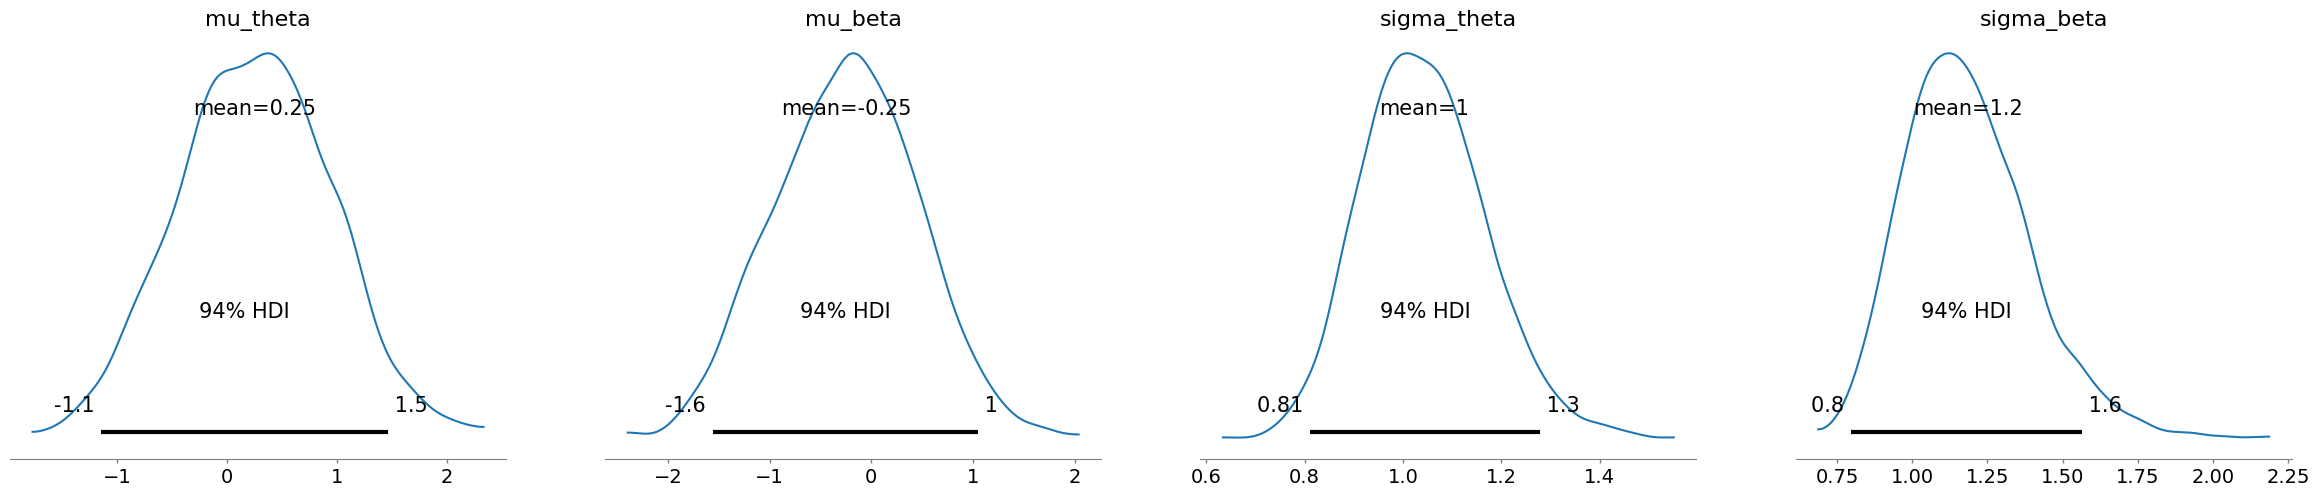

In [ ]:
_ = pm.plot_posterior(trace.posterior[['mu_theta', 'mu_beta', 'sigma_theta', 'sigma_beta']])

# Inciso G

## Utilizar los valores muestreados para aproximar la probabilidad predictiva de que el usuario i−ésimo resuelva la tarea j−ésima sobre los datos faltantes (debe indicar un resultado por cadena). Indicar la probabilidad de que el usuario 4 resuleva la tarea 12. Para calcular probabilidades y esperanzas predictivas no es necesario (ni recomendable) muestrear la distribución predictiva. Basta con las muestras de la distribución a posteriori.

In [ ]:

#### CHEQUEAR
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Se extraen las muestras
theta_samples = trace.posterior["theta"].values  # shape: (chains, draws, n_users)
beta_samples  = trace.posterior["beta"].values   # shape: (chains, draws, n_tasks)

# Se aplanan lass muestras
theta_flat = theta_samples.reshape(-1, theta_samples.shape[-1])
beta_flat  = beta_samples.reshape(-1, beta_samples.shape[-1])

# Se obtiene la probabilidad de que el usuario 4 resuelva la tarea 12
i, j = 3, 11
prob_pred = sigmoid(theta_flat[:, i] - beta_flat[:, j]).mean()

print(f"Probabilidad predictiva de que el usuario 4 resuelva la tarea 12: {prob_pred:.3f}")

Output()

AttributeError: 'InferenceData' object has no attribute 'posterior_predictive'